# Fréquence de mise à jour nécessaire

Nous pouvons dès à présent établir un système nous indiquant quand il faudra mettre à jour notre modèle. Il suffit de mettre en place un système d'Ajusted Rand Score.

Commençons en chargeant notre CSV et en faisant nos imports :



In [25]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas
from datetime import date, timedelta, datetime

import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("data/rfm_data.csv")

Maintenant, on va itérer et calculer le temps écoulé entre aujourd'hui et le nombre de jours depuis la commande :

C:\Users\elect\AppData\Local\Temp\ipykernel_3236\1485413889.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ari_score = ari_score.append(key_value, ignore_index=True)
C:\Users\elect\AppData\Local\Temp\ipykernel_3236\1485413889.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ari_score = ari_score.append(key_value, ignore_index=True)
C:\Users\elect\AppData\Local\Temp\ipykernel_3236\1485413889.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ari_score = ari_score.append(key_value, ignore_index=True)
C:\Users\elect\AppData\Local\Temp\ipykernel_3236\1485413889.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ari_score = ari

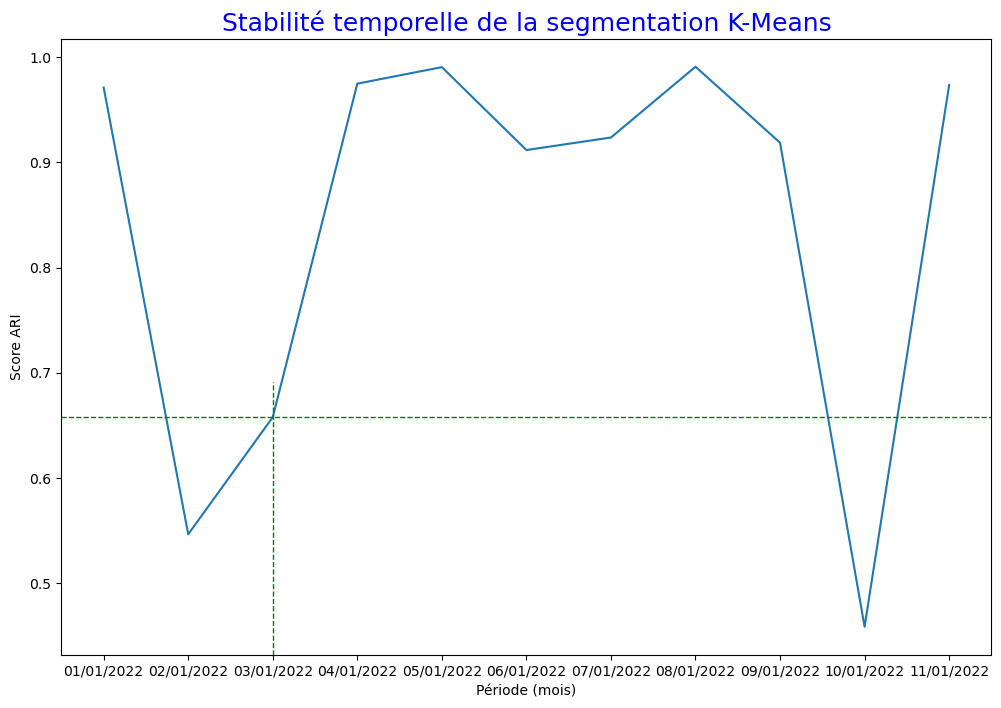

In [26]:
from sklearn.preprocessing import StandardScaler

data['order_purchase_timestamp'] = 'none'

for i, row in data.iterrows():
    data.loc[i, ['order_purchase_timestamp']] = (datetime.now() - timedelta(days=row['(days)last_purchase'])).strftime("%d/%m/%Y")

def kmean_process_date(data_period):
    kmeans = KMeans(n_clusters=6,init='k-means++').fit(data_period)
    kmeans2 = KMeans(n_clusters=6,n_init=1,init='k-means++').fit(data_period)
    return adjusted_rand_score(kmeans2.labels_, kmeans.labels_)

all_dates = {
    "01/01/2022": "02/01/2022",
    "02/01/2022": "03/01/2022",
    "03/01/2022": "04/01/2022",
    "04/01/2022": "05/01/2022",
    "05/01/2022": "06/01/2022",
    "06/01/2022": "07/01/2022",
    "07/01/2022": "08/01/2022",
    "08/01/2022": "09/01/2022",
    "09/01/2022": "10/01/2022",
    "10/01/2022": "11/01/2022",
    "11/01/2022": "12/01/2022"
}

mesurate_ari_by_month = {}

def calculate_kmean_by_month():
    for key in all_dates:
        data_temp = pd.DataFrame({})
        start_date = key
        end_date = all_dates[key]
        for i in range(0, len(data)):
            is_in_period = datetime.strptime(start_date, "%d/%m/%Y") < datetime.strptime(data.at[i, 'order_purchase_timestamp'], '%d/%m/%Y') < datetime.strptime(end_date, "%m/%d/%Y")

            if is_in_period:
                data_var = data.loc[[i]]
                data_temp = pandas.concat([data_temp, data_var])

        data_period = pd.DataFrame({ '(days)last_purchase': data_temp['(days)last_purchase'], 'total_orders': data_temp['total_orders'], 'total_spend': data_temp['total_spend'] })

        mesurate_ari_by_month[start_date] = kmean_process_date(data_period) 

calculate_kmean_by_month()

ari_score = pd.DataFrame({ "period": [], "ARI": [] })

for key in mesurate_ari_by_month:
    key_value = { "period": key, "ARI": mesurate_ari_by_month[key] }
    ari_score = ari_score.append(key_value, ignore_index=True)

fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="period", y="ARI")
plt.axhline(y=ari_score.iloc[2][1], linestyle="--",
            color="green",
            xmax=1,
            linewidth=1)
plt.axvline(x=ari_score.iloc[2][0], linestyle="--",
            color="green",
            ymax=1.1-(ari_score.iloc[2][1]),
            linewidth=1)
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation K-Means",
          fontsize=18,
          color="b")
plt.show()